In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from pandas.tseries.offsets import DateOffset
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM 
from keras.layers import Dropout
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
import pickle
import warnings
import sys
import os
warnings.filterwarnings("ignore")

In [2]:
abs = os.getcwd()
abs = abs.replace("\\src\\Time_series\\Air_Quality","")
sys.path.insert(0, abs   + "\\utils")

In [3]:
from time_series import createXY
from time_series import split_train_test_LSTM
from common import process_check
from common import process_normal
from common import process_standard
from common import process_labelencode
from common import RandomizedSCV
from common import corr_mat
from common import co_mat

In [4]:
df = pd.read_csv(abs + "/dataset/Time_series/Air_Quality/AirQualityUCI.csv")
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10-03-2004,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10-03-2004,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10-03-2004,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10-03-2004,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10-03-2004,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


In [5]:
df = df.drop(['Unnamed: 15', 'Unnamed: 16'], axis=1)
null_data = df[df.isnull().any(axis=1)]

In [6]:
df = df.dropna()

In [7]:
df = df.replace(-200, np.nan)

In [8]:
df['Date'] = pd.to_datetime(df['Date'],dayfirst=True)

In [9]:
h = df['Time'].tolist()
l=[]
for i in range(len(h)):
    l.append(h[i].split(":")[0])
df['hour']=l

In [10]:
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day

In [11]:
cols=["year","month","day","hour"]
df['date'] = df[cols].apply(lambda x: '/'.join(x.values.astype(str)), axis="columns")
df

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,hour,year,month,day,date
0,2004-03-10,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,18,2004,3,10,2004/3/10/18
1,2004-03-10,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,19,2004,3,10,2004/3/10/19
2,2004-03-10,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,20,2004,3,10,2004/3/10/20
3,2004-03-10,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,21,2004,3,10,2004/3/10/21
4,2004-03-10,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,22,2004,3,10,2004/3/10/22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,2005-04-04,10:00:00,3.1,1314.0,NaN,13.5,1101.0,472.0,539.0,190.0,1374.0,1729.0,21.9,29.3,0.7568,10,2005,4,4,2005/4/4/10
9353,2005-04-04,11:00:00,2.4,1163.0,NaN,11.4,1027.0,353.0,604.0,179.0,1264.0,1269.0,24.3,23.7,0.7119,11,2005,4,4,2005/4/4/11
9354,2005-04-04,12:00:00,2.4,1142.0,NaN,12.4,1063.0,293.0,603.0,175.0,1241.0,1092.0,26.9,18.3,0.6406,12,2005,4,4,2005/4/4/12
9355,2005-04-04,13:00:00,2.1,1003.0,NaN,9.5,961.0,235.0,702.0,156.0,1041.0,770.0,28.3,13.5,0.5139,13,2005,4,4,2005/4/4/13


In [12]:
df['date']=pd.to_datetime(df['date'])

In [13]:
del df['Date']
del df['Time']

In [14]:
df.set_index('date', inplace=True)

In [15]:
print(df)

                     CO(GT)  PT08.S1(CO)  NMHC(GT)  C6H6(GT)  PT08.S2(NMHC)  \
date                                                                          
2004-03-10 18:00:00     2.6       1360.0     150.0      11.9         1046.0   
2004-03-10 19:00:00     2.0       1292.0     112.0       9.4          955.0   
2004-03-10 20:00:00     2.2       1402.0      88.0       9.0          939.0   
2004-03-10 21:00:00     2.2       1376.0      80.0       9.2          948.0   
2004-03-10 22:00:00     1.6       1272.0      51.0       6.5          836.0   
...                     ...          ...       ...       ...            ...   
2005-04-04 10:00:00     3.1       1314.0       NaN      13.5         1101.0   
2005-04-04 11:00:00     2.4       1163.0       NaN      11.4         1027.0   
2005-04-04 12:00:00     2.4       1142.0       NaN      12.4         1063.0   
2005-04-04 13:00:00     2.1       1003.0       NaN       9.5          961.0   
2005-04-04 14:00:00     2.2       1071.0       NaN  

In [16]:
df.isnull().sum()

CO(GT)           1683
PT08.S1(CO)       366
NMHC(GT)         8443
C6H6(GT)          366
PT08.S2(NMHC)     366
NOx(GT)          1639
PT08.S3(NOx)      366
NO2(GT)          1642
PT08.S4(NO2)      366
PT08.S5(O3)       366
T                 366
RH                366
AH                366
hour                0
year                0
month               0
day                 0
dtype: int64

In [17]:
del df['NMHC(GT)']

In [18]:
df['CO(GT)'] = df['CO(GT)'].ewm(halflife=4).mean()
df['PT08.S1(CO)'] = df['PT08.S1(CO)'].ewm(halflife=4).mean()
df['C6H6(GT)'] = df['C6H6(GT)'].ewm(halflife=4).mean()
df['PT08.S2(NMHC)'] = df['PT08.S2(NMHC)'].ewm(halflife=4).mean()
df['NOx(GT)'] = df['NOx(GT)'].ewm(halflife=4).mean()
df['PT08.S3(NOx)'] = df['PT08.S3(NOx)'].ewm(halflife=4).mean()
df['NO2(GT)'] = df['NO2(GT)'].ewm(halflife=4).mean()
df['PT08.S4(NO2)'] = df['PT08.S4(NO2)'].ewm(halflife=4).mean()
df['PT08.S5(O3)'] = df['PT08.S5(O3)'].ewm(halflife=4).mean()
df['T'] = df['T'].ewm(halflife=4).mean()
df['RH'] = df['RH'].ewm(halflife=4).mean()
df['AH'] = df['AH'].ewm(halflife=4).mean()

In [19]:
df.isnull().sum()

CO(GT)           0
PT08.S1(CO)      0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
hour             0
year             0
month            0
day              0
dtype: int64

In [20]:
df.shape

(9357, 16)

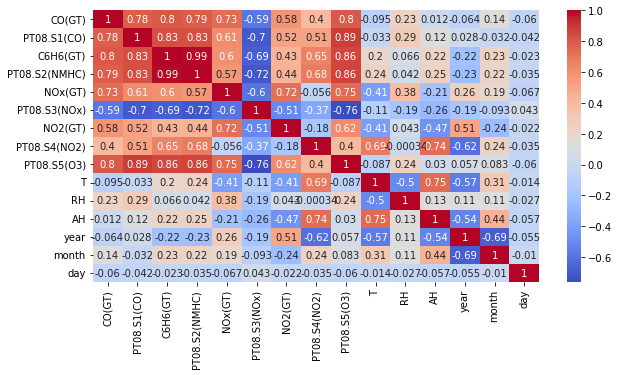

In [21]:
corr_mat(df)

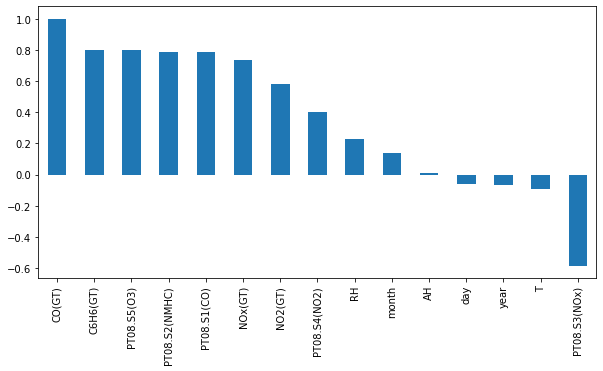

In [22]:
co_mat(df, 'CO(GT)')

In [23]:
df.corr()['CO(GT)'].sort_values(ascending=False).abs()

CO(GT)           1.000000
C6H6(GT)         0.801497
PT08.S5(O3)      0.799460
PT08.S2(NMHC)    0.789460
PT08.S1(CO)      0.784967
NOx(GT)          0.732936
NO2(GT)          0.581823
PT08.S4(NO2)     0.398735
RH               0.228789
month            0.138862
AH               0.011891
day              0.059850
year             0.064402
T                0.095101
PT08.S3(NOx)     0.585400
Name: CO(GT), dtype: float64

In [24]:
del df['AH']

In [25]:
sca, norm = process_check(df)

In [26]:
print(sca, norm)

['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S4(NO2)', 'T', 'RH', 'hour', 'month', 'day'] ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S5(O3)', 'year']


In [27]:
sca = ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S4(NO2)', 'T', 'RH', 'hour', 'month', 'day']
norm = ['C6H6(GT)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S5(O3)', 'year']

In [28]:
df[sca], stand_ind = process_standard(df, sca)

In [29]:
df[norm], normal_ind = process_normal(df, norm)

In [30]:
norm = ['CO(GT)']
df[norm], normal_COGT_conc = process_normal(df, norm)

In [31]:
df_1 = df.to_numpy()

print(df_1)


[[ 0.31750401  1.63092824  0.31180053 ...  0.         -0.96287933
  -0.66720732]
 [ 0.27497334  1.39817501  0.27254577 ...  0.         -0.96287933
  -0.66720732]
 [ 0.27117989  1.59338642  0.25505309 ...  0.         -0.96287933
  -0.66720732]
 ...
 [ 0.30282767  0.36588136  0.26827156 ...  1.         -0.6720105
  -1.34839214]
 [ 0.29450352  0.20925267  0.26415962 ...  1.         -0.6720105
  -1.34839214]
 [ 0.28972392  0.14571602  0.27173946 ...  1.         -0.6720105
  -1.34839214]]


In [32]:
df_2 = df['CO(GT)'].to_numpy()

print(df_2)

[0.31750401 0.27497334 0.27117989 ... 0.30282767 0.29450352 0.28972392]


In [33]:
X,Y=createXY(df_1,df_2,0,None,96,12)
#Here we have to bifurcate data in terms of window size having the large size of window good for accuracy but taking large
#time for computation and horizon is how much data you want to forecast or "y"

In [34]:
X.shape, Y.shape

((9249, 96, 15), (9249, 12))

In [35]:
X[0]

array([[ 0.31750401,  1.63092824,  0.31180053, ...,  0.        ,
        -0.96287933, -0.66720732],
       [ 0.27497334,  1.39817501,  0.27254577, ...,  0.        ,
        -0.96287933, -0.66720732],
       [ 0.27117989,  1.59338642,  0.25505309, ...,  0.        ,
        -0.96287933, -0.66720732],
       ...,
       [ 0.24857177,  1.12817788,  0.20096822, ...,  0.        ,
        -0.96287933, -0.21308411],
       [ 0.26824139,  1.30641493,  0.21860204, ...,  0.        ,
        -0.96287933, -0.21308411],
       [ 0.28255097,  1.43624329,  0.23389015, ...,  0.        ,
        -0.96287933, -0.21308411]])

In [36]:
print(Y[0])
print(Y[1])

[0.3331743  0.39986842 0.40340326 0.37918248 0.36095504 0.33731308
 0.31746779 0.30080474 0.27223343 0.27223343 0.24212552 0.22753733]
[0.39986842 0.40340326 0.37918248 0.36095504 0.33731308 0.31746779
 0.30080474 0.27223343 0.27223343 0.24212552 0.22753733 0.23418566]


In [37]:
X_train, y_train, X_valid, y_valid, X_test, y_test = split_train_test_LSTM(X, Y, 0.2, 0.1)

In [38]:
tf.config.experimental.list_physical_devices()
len(tf.config.list_physical_devices('GPU'))>0

True

In [39]:
model = Sequential()
model.add(LSTM(128,return_sequences=True,input_shape=(96,15)))#Here I have given 128 nural network because I have given 16 column as input 
model.add(LSTM(256))#minimum number of neurons should be 16 or atleast multiple of it
model.add(Dropout(0.2))#Dropout is very helpful in dealing with the oversfitting,here it randomly removes 20% of neurons while processing
model.add(Dense(48))
model.add(Dropout(0.2))
model.add(Dense(12))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train,y_train, epochs=25, batch_size=50, verbose=2,validation_data=(X_valid,y_valid))

Epoch 1/25
130/130 - 12s - loss: 0.0135 - val_loss: 0.0129 - 12s/epoch - 91ms/step
Epoch 2/25
130/130 - 4s - loss: 0.0079 - val_loss: 0.0141 - 4s/epoch - 28ms/step
Epoch 3/25
130/130 - 4s - loss: 0.0066 - val_loss: 0.0150 - 4s/epoch - 27ms/step
Epoch 4/25
130/130 - 4s - loss: 0.0059 - val_loss: 0.0189 - 4s/epoch - 28ms/step
Epoch 5/25
130/130 - 4s - loss: 0.0053 - val_loss: 0.0147 - 4s/epoch - 28ms/step
Epoch 6/25
130/130 - 4s - loss: 0.0048 - val_loss: 0.0117 - 4s/epoch - 28ms/step
Epoch 7/25
130/130 - 4s - loss: 0.0043 - val_loss: 0.0139 - 4s/epoch - 27ms/step
Epoch 8/25
130/130 - 4s - loss: 0.0037 - val_loss: 0.0149 - 4s/epoch - 27ms/step
Epoch 9/25
130/130 - 4s - loss: 0.0032 - val_loss: 0.0115 - 4s/epoch - 27ms/step
Epoch 10/25
130/130 - 4s - loss: 0.0030 - val_loss: 0.0127 - 4s/epoch - 28ms/step
Epoch 11/25
130/130 - 4s - loss: 0.0026 - val_loss: 0.0122 - 4s/epoch - 28ms/step
Epoch 12/25
130/130 - 4s - loss: 0.0023 - val_loss: 0.0139 - 4s/epoch - 27ms/step
Epoch 13/25
130/130 - 4

In [40]:
prediction=model.predict(X_test)
print("prediction\n", prediction)
print("\nPrediction Shape-",prediction.shape)

29/29 [==============================] - 1s 13ms/step
prediction
 [[0.25394785 0.24786547 0.24491572 ... 0.20568287 0.20038459 0.19525588]
 [0.2611463  0.25738132 0.25559917 ... 0.20037538 0.19604418 0.1926803 ]
 [0.2738362  0.2707841  0.26807484 ... 0.19951145 0.1970906  0.19572277]
 ...
 [0.19744551 0.19312489 0.18910861 ... 0.15756288 0.1736066  0.17765164]
 [0.18665063 0.17736694 0.1719075  ... 0.162406   0.17189732 0.17082234]
 [0.16704242 0.15797634 0.15696745 ... 0.15637657 0.16196561 0.15975219]]

Prediction Shape- (924, 12)


In [41]:
prediction[2,0]

0.2738362

In [42]:
Y_test = []
for i in range(0,924):
    Y_test.append(y_test[i,0])
Y_test = np.array(Y_test)
print(y_test)
print(Y_test)

[[0.25686566 0.27512341 0.30933752 ... 0.32416926 0.30018675 0.27171545]
 [0.27512341 0.30933752 0.34006643 ... 0.30018675 0.27171545 0.24571742]
 [0.30933752 0.34006643 0.36370175 ... 0.27171545 0.24571742 0.21971372]
 ...
 [0.14468312 0.12858021 0.11296319 ... 0.30784075 0.30509607 0.30282767]
 [0.12858021 0.11296319 0.11296319 ... 0.30509607 0.30282767 0.29450352]
 [0.11296319 0.11296319 0.10019938 ... 0.30282767 0.29450352 0.28972392]]
[0.25686566 0.27512341 0.30933752 0.34006643 0.36370175 0.37513253
 0.36171698 0.34419816 0.33784327 0.32416926 0.30018675 0.27171545
 0.24571742 0.21971372 0.20202288 0.19547277 0.23569996 0.31523546
 0.34884446 0.35839825 0.33319074 0.3203074  0.3115529  0.29588469
 0.28686465 0.28551065 0.29475526 0.31498767 0.34445881 0.33394036
 0.33340138 0.33294817 0.33464339 0.32153481 0.30635956 0.29775149
 0.28220817 0.26083311 0.23455425 0.21453287 0.1976971  0.19392101
 0.19074573 0.18599948 0.20277017 0.22517723 0.24609537 0.25745681
 0.26493441 0.275374

In [43]:
Pred = []
for i in range(0,924):
    Pred.append(prediction[i,0])
Pred = np.array(Pred)
print(prediction)
print(Pred)

[[0.25394785 0.24786547 0.24491572 ... 0.20568287 0.20038459 0.19525588]
 [0.2611463  0.25738132 0.25559917 ... 0.20037538 0.19604418 0.1926803 ]
 [0.2738362  0.2707841  0.26807484 ... 0.19951145 0.1970906  0.19572277]
 ...
 [0.19744551 0.19312489 0.18910861 ... 0.15756288 0.1736066  0.17765164]
 [0.18665063 0.17736694 0.1719075  ... 0.162406   0.17189732 0.17082234]
 [0.16704242 0.15797634 0.15696745 ... 0.15637657 0.16196561 0.15975219]]
[0.25394785 0.2611463  0.2738362  0.28806528 0.3031521  0.31572294
 0.32440716 0.32850677 0.32649595 0.3215764  0.3254614  0.3110113
 0.29625028 0.28907695 0.2894576  0.29292858 0.29784125 0.30149984
 0.3089169  0.31810156 0.32036015 0.31568417 0.3061586  0.3027729
 0.30680802 0.31614175 0.32815546 0.33903265 0.3477863  0.35272735
 0.35436893 0.34878224 0.3415845  0.3334118  0.33324528 0.31480035
 0.29538342 0.28641337 0.28884605 0.29796684 0.30821276 0.31399775
 0.31515494 0.31076562 0.30052602 0.28612202 0.27106592 0.2574942
 0.24570704 0.23446925 

In [44]:
predictions = np.reshape(Pred, (-1,1 ))
predictions.shape

(924, 1)

In [45]:
y_pred = normal_COGT_conc.inverse_transform(predictions)
y_pred

array([[2.1129458 ],
       [2.1681101 ],
       [2.2653575 ],
       [2.3744001 ],
       [2.490016  ],
       [2.586351  ],
       [2.6529012 ],
       [2.684318  ],
       [2.6689084 ],
       [2.631208  ],
       [2.6609802 ],
       [2.550244  ],
       [2.4371247 ],
       [2.382153  ],
       [2.3850698 ],
       [2.4116693 ],
       [2.449317  ],
       [2.477354  ],
       [2.5341938 ],
       [2.6045792 ],
       [2.6218877 ],
       [2.5860538 ],
       [2.5130558 ],
       [2.4871101 ],
       [2.5180326 ],
       [2.5895605 ],
       [2.6816258 ],
       [2.7649817 ],
       [2.8320642 ],
       [2.8699293 ],
       [2.8825092 ],
       [2.8396964 ],
       [2.7845376 ],
       [2.7219071 ],
       [2.7206311 ],
       [2.5792809 ],
       [2.4304817 ],
       [2.361741  ],
       [2.3803835 ],
       [2.4502795 ],
       [2.5287976 ],
       [2.5731301 ],
       [2.581998  ],
       [2.5483613 ],
       [2.4698913 ],
       [2.3595083 ],
       [2.2441278 ],
       [2.140

In [46]:
y_pred.shape


(924, 1)

In [47]:
Y_test.shape

(924,)

In [48]:
Y_test = np.reshape(Y_test, (-1,1 ))

In [49]:
Y_test.shape

(924, 1)

In [50]:
Y_test = normal_COGT_conc.inverse_transform(Y_test)
Y_test

array([[2.13530611],
       [2.27522193],
       [2.53741718],
       [2.7729041 ],
       [2.95403022],
       [3.04162845],
       [2.93882017],
       [2.80456707],
       [2.75586722],
       [2.65107828],
       [2.46729145],
       [2.24910544],
       [2.049873  ],
       [1.85059714],
       [1.71502577],
       [1.66482984],
       [1.97310554],
       [2.58261525],
       [2.84017334],
       [2.91338752],
       [2.72021316],
       [2.62148342],
       [2.55439442],
       [2.43432319],
       [2.36519933],
       [2.35482317],
       [2.42566797],
       [2.58071634],
       [2.80656455],
       [2.72595778],
       [2.72182735],
       [2.71835422],
       [2.73134537],
       [2.63088949],
       [2.51459597],
       [2.44862921],
       [2.329515  ],
       [2.16571012],
       [1.96432557],
       [1.81089437],
       [1.68187566],
       [1.65293812],
       [1.62860478],
       [1.59223252],
       [1.72075247],
       [1.89246603],
       [2.05276939],
       [2.139

In [51]:
Y_test.shape

(924, 1)

In [53]:
y_test = np.squeeze(Y_test)
y_test.shape

(924,)

In [55]:
Y_pred = np.squeeze(y_pred)
Y_pred.shape

(924,)

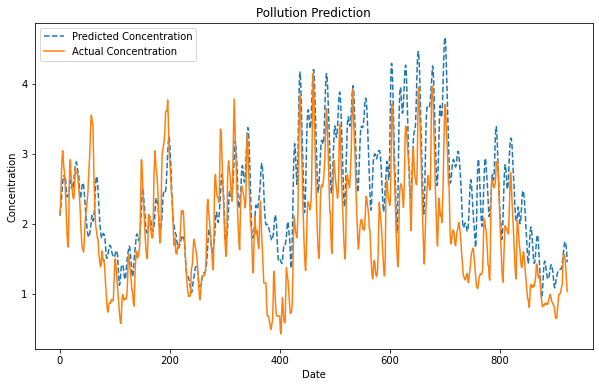

In [76]:
df = pd.DataFrame(data={'Predictions': Y_pred,
                          'Actuals':y_test
                          })
plt.plot(df['Predictions'], linestyle='dashed', label='Predicted Concentration')
plt.plot(df['Actuals'],label='Actual Concentration')
plt.title('Pollution Prediction')
plt.xlabel('Date')
plt.ylabel('Concentration')
plt.legend()
plt.show()

In [73]:
mape = np.mean(np.abs((y_test - Y_pred) / y_test))*100
mape

39.13813019628545

In [63]:
y_pred.shape

(924,)

In [78]:
pickle.dump(stand_ind, open(abs + "\\output\\Time Series\\Air_Quality\\stand_concentration.pkl", 'wb'))
pickle.dump(normal_ind, open(abs + "\\output\\Time Series\\Air_Quality\\normal_concentration.pkl", 'wb'))
pickle.dump(normal_COGT_conc, open(abs + "\\output\\Time Series\\Air_Quality\\normal_COGT_conc.pkl", 'wb'))

In [79]:
model.save(abs + "\\output\\Time Series\\Air_Quality\\Model.h5")
print('Model Saved!')

Model Saved!
